In [8]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras import layers
from tensorflow.keras.layers import Layer, Dense, Input, LeakyReLU, Reshape
from tensorflow.keras.layers import UpSampling2D, AveragePooling2D, Flatten, Lambda
from tensorflow.keras.activations import relu, tanh
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.initializers import he_normal
from tensorflow.keras.constraints import max_norm
import numpy as np
import matplotlib.pyplot as plt
import os
import random
from glob import glob
from functools import partial
import time

import warnings
warnings.filterwarnings('ignore')
print("Tensorflow", tf.__version__)


Tensorflow 2.2.0


In [9]:
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
logical_gpus = tf.config.experimental.list_logical_devices('GPU')
print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")

4 Physical GPUs, 1 Logical GPU


In [10]:
PATH = "celeba_hq/"
BUFFER_SIZE = 200
IMAGE_RESOLUTION = 128

def load(res, image_file):
    image = tf.io.read_file(image_file)
    image = tf.image.decode_jpeg(image)
    image = tf.image.resize(image, [res, res],
                            method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    image = tf.cast(image, tf.float32)
    image = (image /127.5) - 1
    return image
        
train_datasets = {}
train_images = glob(PATH+'train/**/*.jpg')
random.shuffle(train_images)
train_dataset_list = tf.data.Dataset.from_tensor_slices(train_images)

n_workers = tf.data.experimental.AUTOTUNE
BATCH_SIZE = {2: 16, 3: 16, 4: 16, 5: 16, 6: 16, 7: 8, 8: 4, 9: 4, 10:4}
TRAIN_STEP_RATIO = {k: BATCH_SIZE[2]/v for k, v in BATCH_SIZE.items()}
for log2_res in range(2, int(np.log2(IMAGE_RESOLUTION))+1):
    res = 2**log2_res
    temp = train_dataset_list.map(partial(load, res),  num_parallel_calls= n_workers)

    temp = temp.shuffle(BUFFER_SIZE).batch(BATCH_SIZE[log2_res], drop_remainder=True).repeat()
    train_datasets[log2_res] = temp

In [83]:
def plot_images(images, log2_res, fname=''):    
    scales = {2:0.5,
             3:1,
             4:2,
             5:3,
             6:4,
             7:5,
             8:6,
             9:7,
             10:8}
    scale = scales[log2_res]
    
    grid_col = min(16, int(16//scale))
    grid_row = images.shape[0]//grid_col
    grid_row = min(2, grid_row)

    f, axarr = plt.subplots(grid_row, grid_col, figsize=(grid_col*scale, grid_row*scale))

    for row in range(grid_row):
        ax = axarr if grid_row==1 else axarr[row]
        for col in range(grid_col):
            ax[col].imshow(images[row*grid_col + col])
            ax[col].axis('off')
    plt.show()
    if fname:
        print("image name", fname)
        f.savefig(fname)

In [12]:
class PixelNorm(Layer):
    def __init__(self, epsilon=1e-8):
        super(PixelNorm, self).__init__()
        self.epsilon = epsilon
        
    def call(self, input_tensor):
        return input_tensor / tf.math.sqrt(tf.reduce_mean(input_tensor**2, axis=-1, keepdims=True) + self.epsilon)

class MinibatchStd(Layer): 
    def __init__(self, group_size=4, epsilon=1e-8): 

        super(MinibatchStd, self).__init__() 
        self.epsilon = epsilon 
        self.group_size = group_size 
        
    def call(self, input_tensor): 

        n, h, w, c = input_tensor.shape 
        x = tf.reshape(input_tensor, [self.group_size, -1, h, w, c]) 
        group_mean, group_var = tf.nn.moments(x, axes=(0), keepdims=False) 
        group_std = tf.sqrt(group_var + self.epsilon) 
        avg_std = tf.reduce_mean(group_std, axis=[1,2,3], keepdims=True) 
        x = tf.tile(avg_std, [self.group_size, h, w, 1]) 

        return tf.concat([input_tensor, x], axis=-1) 
    
class FadeIn(Layer):
    @tf.function
    def call(self, input_alpha, a, b):
        alpha = tf.reduce_mean(input_alpha)
        y = alpha * a + (1. - alpha) * b
        return y
    
def wasserstein_loss(y_true, y_pred):
    
    return -tf.reduce_mean(y_true * y_pred)



In [13]:
class Conv2D(Layer):
    def __init__(self, out_channels, kernel=3, gain=2, **kwargs):
        super(Conv2D, self).__init__(kwargs)
        self.kernel = kernel
        self.out_channels = out_channels
        self.gain = gain
        self.pad = kernel!=1
        
    def build(self, input_shape):
        self.in_channels = input_shape[-1]

        initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=1.)        
        self.w = self.add_weight(shape=[self.kernel,
                                        self.kernel,
                                        self.in_channels,
                                        self.out_channels],
                                initializer=initializer,
                                trainable=True, name='kernel')
        
        self.b = self.add_weight(shape=(self.out_channels,),
                                initializer='zeros',
                                trainable=True, name='bias')
        
        fan_in = self.kernel*self.kernel*self.in_channels
        self.scale = tf.sqrt(self.gain/fan_in)
        
    def call(self, inputs):
        if self.pad:
            x = tf.pad(inputs, [[0, 0], [1, 1], [1, 1], [0, 0]], mode='REFLECT')
        else:
            x = inputs
        output = tf.nn.conv2d(x, self.scale*self.w, strides=1, padding="VALID") + self.b
        return output
    
class Dense(Layer):
    def __init__(self, units, gain=2, lrmul=1, **kwargs):
        super(Dense, self).__init__(kwargs)
        self.units = units
        self.gain = gain
        self.lrmul = lrmul
        
    def build(self, input_shape):
        self.in_channels = input_shape[-1]
        initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=1./self.lrmul)        
        self.w = self.add_weight(shape=[self.in_channels,
                                        self.units],
                                initializer=initializer,
                                trainable=True, name='kernel')
        
        self.b = self.add_weight(shape=(self.units,),
                                initializer='zeros',
                                trainable=True, name='bias')
        
        fan_in = self.in_channels
        self.scale = tf.sqrt(self.gain/fan_in)
        
    @tf.function
    def call(self, inputs):
        output = tf.matmul(inputs, self.scale*self.w) + self.b
        return output*self.lrmul
    

In [14]:
class AddNoise(Layer):
        
    def build(self, input_shape):
        n, h, w, c = input_shape[0]

        initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=1.)
        self.B = self.add_weight(shape=[1, 1, 1, c],
                                initializer=initializer,
                                trainable=True, name='kernel')
        
    def call(self, inputs):
        x, noise = inputs
        output = x + self.B * noise
        return output

class AdaIN(Layer):
    def __init__(self, gain=1, **kwargs):
        super(AdaIN, self).__init__(kwargs)
        self.gain = gain
        
    def build(self, input_shapes):
        x_shape = input_shapes[0]
        w_shape = input_shapes[1]

        self.w_channels = w_shape[-1]
        self.x_channels = x_shape[-1]
        
        self.dense_1 = Dense(self.x_channels, gain=1)
        self.dense_2 = Dense(self.x_channels, gain=1)
        
        
    def call(self, inputs):
        x, w = inputs
        ys = tf.reshape(self.dense_1(w), (-1, 1, 1, self.x_channels))
        yb = tf.reshape(self.dense_2(w), (-1, 1, 1, self.x_channels))
        
        output = ys*x + yb
        return output    

In [26]:
class StyleGAN():
    def __init__(self, z_dim=512, resolution=512, load_path=None, start_log2_res=2):
        self.start_log2_res = start_log2_res
        self.resolution = resolution
        self.log2_resolution = int(np.log2(resolution))
        self.log2_res_to_filter_size = {
            0: 512,
            1: 512,
            2: 512, # 4x4
            3: 512, # 8x8
            4: 512, # 16x16
            5: 512, # 32x32
            6: 256, # 64x64
            7: 128, # 128x128
            8: 64,  # 256x256
            9: 32,  # 512x512
            10: 16} # 1024x1024 

        self.z_dim = z_dim
        self.initializer = tf.keras.initializers.RandomNormal(0., 1.)
        self.opt_init = {'learning_rate':1e-3, 'beta_1':0.0, 'beta_2':0.99, 'epsilon':1e-8}

        self.g_loss = 0.
        self.d_loss = 0.
        self.build_mapping()
        self.build_all_generators()
        self.build_all_discriminators()
        
        if load_path:
            self.load_checkpoint(load_path)

        # initialize generator with the base
        
        dummy_alpha = Input(shape=(1), name='DummyAlpha')
        #z = Input(shape=(self.z_dim), name='z')        
        input_const = Input(shape=(4,4,512), name='ConstInput')
        w = Input(shape=(8, 512))
        #w = self.mapping(z)
        
        output = self.generator_blocks[2]([input_const, 
                                          w[:,0],
                                          self.noise_inputs[2]])
        rgb = self.to_rgb[2](output)
        self.generator = Model([input_const, 
                                w,
                                dummy_alpha,
                                self.noise_inputs], rgb)

        # build base discriminator
        input_image = Input(shape=(4,4,3))
        alpha = Input(shape=(1))           
        x = self.from_rgb[2](input_image)  
        pred = self.discriminator_blocks[2](x)

        self.discriminator = Model([input_image, alpha], pred,
                                    name='discriminator_4x4')

        self.optimizer_discriminator = Adam(**self.opt_init)                

        self.discriminator.trainable = False

        # build composite model
        pred = self.discriminator([self.generator.output, 
                                   self.generator.input[2]])

        self.model = Model(inputs=[self.generator.input],
                          outputs=pred)
        self.model.compile(loss=wasserstein_loss, optimizer=Adam(**self.opt_init))

        checkpoint_path = f"./checkpoints/stylegan/"
        self.ckpt = tf.train.Checkpoint(generator = self.generator,
                                       discriminator = self.discriminator)
        self.ckpt_manager = tf.train.CheckpointManager(self.ckpt, checkpoint_path, max_to_keep=40)
        
            
    def load_checkpoint(self, ckpt_path):
        self.grow_model(self.start_log2_res)
        self.ckpt.restore(ckpt_path)
        
    def build_all_generators(self):

        # build all the generator block
        self.to_rgb = {}
        self.generator_blocks = {}
        self.noise_inputs = {}
        self.w_inputs = {}
        
        for log2_res in range(2, self.log2_resolution+1):
            res = 2**log2_res
            self.noise_inputs[log2_res] = Input(shape=(res, res, 1))
            self.w_inputs[log2_res] = Input(shape=(512))
            filter_n = self.log2_res_to_filter_size[log2_res]            
            self.to_rgb[log2_res] = self.build_to_rgb(res, filter_n)
            if log2_res == 2:
                input_shape = (4, 4, 512)
            else:
                input_shape = self.generator_blocks[log2_res-1].output[0].shape
            gen_block = self.build_generator_block(log2_res, input_shape)
            self.generator_blocks[log2_res] = gen_block
            
            
    def build_mapping(self):
        # Mapping Network
        z = Input(shape=(self.z_dim))
        w = PixelNorm()(z)
        for i in range(8):
            w = Dense(512, lrmul=0.01)(w)
            w = LeakyReLU(0.2)(w)
        
        w = tf.tile(tf.expand_dims(w, 1), (1,8,1))            
        self.mapping = Model(z, w, name='mapping')
        
    def build_generator_block(self, log2_res, input_shape):
        res = int(2**log2_res)
        res_name = f'{res}x{res}'
        filter_n = self.log2_res_to_filter_size[log2_res]

        input_tensor = Input(shape=input_shape)
        x = input_tensor
        
        w = Input(shape=512)
        noise = Input(shape=(res, res, 1))

        if log2_res > 2:
            x = UpSampling2D((2,2))(x)
            x = Conv2D(filter_n, 3, name=f'gen_{res_name}_conv1')(x)

        x = AddNoise()([x, noise])
        x = LeakyReLU(0.2)(x)
        x = PixelNorm()(x)
        x = AdaIN()([x, w])
        
        # ADD NOISE
        x = Conv2D(filter_n, 3, name=f'gen_{res_name}_conv2')(x)
        x = AddNoise()([x, noise])    
        x = LeakyReLU(0.2)(x)
        x = PixelNorm()(x)      
        x = AdaIN()([x, w])

        return Model([input_tensor, 
                      w, 
                      noise
                     ], x, 
                     name=f'genblock_{res}_x_{res}') 


        
    def build_discriminator_block(self, log2_res, input_shape):

        filter_n = self.log2_res_to_filter_size[log2_res]        
        input_tensor = Input(shape=input_shape)
        
        # First conv
        x = Conv2D(filter_n, 3)(input_tensor)
        x = LeakyReLU(0.2)(x)
        
        # Second conv + downsample
        filter_n = self.log2_res_to_filter_size[log2_res-1]        
        x = Conv2D(filter_n, 3,)(x)
        x = LeakyReLU(0.2)(x)
        x = AveragePooling2D((2,2))(x)
        
        res = 2**log2_res
        return Model(input_tensor, x, 
                     name=f'disc_block_{res}_x_{res}') 
        
        
    def build_discriminator_base(self, input_shape):

        input_tensor = Input(shape=input_shape)

        x = MinibatchStd()(input_tensor)
        #x = input_tensor
        x = Conv2D(512, 3, name='gen_4x4_conv1')(x)
        x = LeakyReLU(0.2)(x)
        x = Flatten()(x)
        
        x = Dense(512, name='gen_4x4_dense1')(x)
        x = LeakyReLU(0.2)(x)

        x = Dense(1, name='gen_4x4_dense2')(x)
        
        return Model(input_tensor, x, 
                     name='discriminator_base') 

    def build_to_rgb(self, res, filter_n):
        
        return Sequential([Input(shape=(res, res, filter_n)),
                           Conv2D(3, 1, gain=1, activation=None,
                                  name=f'to_rgb_{res}x{res}_conv')],
                         name=f'to_rgb_{res}x{res}')
    
    def build_from_rgb(self, res, filter_n):
        
        return Sequential([Input(shape=(res, res, 3)),
                           Conv2D(filter_n, 1,
                                  name=f'from_rgb_{res}x{res}_conv'),
                           LeakyReLU(0.2)],
                         name=f'from_rgb_{res}x{res}')
    
    def build_all_discriminators(self):
        
        self.from_rgb = {}
        self.discriminator_blocks = {}
        
        # all but the final block
        for log2_res in range(self.log2_resolution, 1, -1):
            res = 2**log2_res
            filter_n = self.log2_res_to_filter_size[log2_res]            
            self.from_rgb[log2_res] = self.build_from_rgb(res, filter_n)
            
            input_shape = (res, res, filter_n)
            self.discriminator_blocks[log2_res] = self.build_discriminator_block(log2_res, input_shape)

        # last block at 4x4 resolution
        log2_res = 2
        filter_n = self.log2_res_to_filter_size[log2_res]            
        self.from_rgb[log2_res] = self.build_from_rgb(4, filter_n)
        res = 2**log2_res
        input_shape = (res, res, filter_n)            
        self.discriminator_blocks[log2_res] = self.build_discriminator_base(input_shape)
                                       
        
    def grow_discriminator(self, log2_res):
        res = 2**log2_res 

        input_image = Input(shape=(res, res, 3))
        alpha = Input(shape=(1))
        
        x = self.from_rgb[log2_res](input_image)
        x = self.discriminator_blocks[log2_res](x)        
        
        downsized_image = AveragePooling2D((2,2))(input_image)
        y = self.from_rgb[log2_res-1](downsized_image)
        
        x = FadeIn()(alpha, x, y)
        for i in range (log2_res-1, 1, -1):
            x = self.discriminator_blocks[i](x)
            
        self.discriminator =  Model([input_image, alpha], x,
                     name=f'discriminator_{res}_x_{res}')
        
        self.optimizer_discriminator = Adam(**self.opt_init)        
                
    def grow_generator(self, log2_res):
        res = 2**log2_res
        alpha = Input(shape=(1))
        
        #w = self.mapping.output
        w = Input(shape=(8, 512))
        input_const = Input(shape=(4,4,512))
        
        x = self.generator_blocks[2]([input_const, 
                                          w[:,0],
                                          self.noise_inputs[2]])
        
        
        for i in range(3, log2_res):
            x = self.generator_blocks[i]([x, w[:,log2_res-1], self.noise_inputs[i]])
        
        old_rgb = self.to_rgb[log2_res-1](x)
        old_rgb = UpSampling2D((2,2))(old_rgb)
        
        x = self.generator_blocks[log2_res]([x, w[:,log2_res-1], self.noise_inputs[log2_res]])
        new_rgb = self.to_rgb[log2_res](x)
        rgb = FadeIn()(alpha, new_rgb, old_rgb)
        
        
        self.generator = Model([input_const,
                                w,
                                alpha,
                                self.noise_inputs], 
                                rgb, 
                        name=f'generator_{res}_x_{res}')         
                         
    def grow_model(self, log2_res):
        tf.keras.backend.clear_session()
        res = 2**log2_res
        print(f"Growing model to {res}x{res}")
            
        self.grow_generator(log2_res)
        self.grow_discriminator(log2_res)

        self.discriminator.trainable = False

        pred = self.discriminator([self.generator.output, 
                                   self.generator.input[2]])

        self.model = Model(inputs=self.generator.input,
                          outputs=pred)
        
        self.model.compile(loss=wasserstein_loss, 
                           optimizer=Adam(**self.opt_init))
    
    def train_discriminator_wgan_gp(self, real_images, alpha):
        
        batch_size = real_images.shape[0]
        const_input = tf.ones((batch_size, 4, 4, 512))        
        noise = self.generate_noise(batch_size)
        
        real_labels = tf.ones(batch_size)
        fake_labels = -tf.ones(batch_size)
        
        z = tf.random.normal((batch_size, self.z_dim))        
        w = self.mapping(z)
        fake_images = self.generator([const_input, w, alpha, noise])
        
        
        with tf.GradientTape() as gradient_tape,\
             tf.GradientTape() as total_tape:
            
            # forward pass
            pred_fake = self.discriminator([fake_images, alpha])
            pred_real = self.discriminator([real_images, alpha])
                  
            epsilon = tf.random.uniform((batch_size,1,1,1))
            interpolates = epsilon*real_images + (1-epsilon)*fake_images
            gradient_tape.watch(interpolates)
            pred_fake_grad = self.discriminator([interpolates, alpha])
            
            # calculate losses
            loss_fake = wasserstein_loss(fake_labels, pred_fake)
            loss_real = wasserstein_loss(real_labels, pred_real)
            loss_fake_grad = wasserstein_loss(fake_labels, pred_fake_grad)
            
            
            # gradient penalty      
            gradients_fake = gradient_tape.gradient(loss_fake_grad, [interpolates])
            gradient_penalty = self.gradient_loss(gradients_fake)
     
            # drift loss
            all_pred = tf.concat([pred_fake, pred_real], axis=0)
            drift_loss = 0.001 * tf.reduce_mean(all_pred**2)
            
            total_loss = loss_fake + loss_real + gradient_penalty + drift_loss
            
            # apply gradients
            gradients = total_tape.gradient(total_loss, self.discriminator.variables)
            
            self.optimizer_discriminator.apply_gradients(zip(gradients, self.discriminator.variables))


        return total_loss
    
    def generate_noise(self, batch_size):
        noise = [tf.random.normal((batch_size, 2**res, 2**res, 1)) \
                 for res in range(2, self.log2_resolution+1)]
        return noise
    
    def train_step(self,  log2_res, data_gen, alpha):
        real_images = next(data_gen)
        self.d_loss = self.train_discriminator_wgan_gp(real_images, alpha)

        real_images = next(data_gen)
        batch_size = real_images.shape[0]
        real_labels = tf.ones(batch_size)
        
        z = tf.random.normal((batch_size, self.z_dim))
        w = self.mapping(z)
        const_input = tf.ones((batch_size, 4, 4, 512))        
        noise = self.generate_noise(batch_size)
        self.g_loss = self.model.train_on_batch([const_input, w, alpha, noise], 
                                                real_labels)

    
    def generate(self, z):
        batch_size = z.shape[0]
        const_input = tf.ones((batch_size, 4, 4, 512))        
        noise = self.generate_noise(batch_size)
        w = self.mapping(z)
        images = self.generator([const_input, w, self.alpha, noise])
        images = np.clip((images*0.5 + 0.5)*255, 0, 255)
        return images.astype(np.uint8)
        
        
    def checkpoint(self, z, log2_res, step):
        res = 2**log2_res
        prefix = f'res_{res}x{res}_{step}'
        ckpt_save_path = self.ckpt_manager.save()
        print('Saving checkpoint',ckpt_save_path)
        
        images = self.generate(z)
        plot_images(images, log2_res, f"./save_images/{prefix}.jpg")
        
    def gradient_loss(self, grad):
        loss = tf.square(grad)
        loss = tf.reduce_sum(loss, axis=np.arange(1,len(loss.shape)))
        loss = tf.sqrt(loss)
        loss = tf.reduce_mean(tf.square(loss - 1))
        self.penalty_const = 10
        loss = self.penalty_const * loss
        return loss
    
    def train(self, datasets, steps_per_phase = 1000, tick_interval=500):
        self.val_z = tf.random.normal((12, self.z_dim))
        
        for log2_res in range(self.start_log2_res, self.log2_resolution+1, 1):
            start_time = time.time()
            self.current_log2_res = log2_res
            
            res = 2**log2_res
            data_gen = iter(datasets[log2_res])
            print(f"Resolution {res}x{res}")
            
            for state in ['TRANSITION','STABLE']:
                if state == 'TRANSITION' and log2_res == 2:
                    continue
                
                steps = int(TRAIN_STEP_RATIO[log2_res] * steps_per_phase)
                interval = int(TRAIN_STEP_RATIO[log2_res] * tick_interval)
                for step in range(0, steps):
                    alpha = step/steps if state == 'TRANSITION' else 1.
                    self.alpha = np.array([[alpha]])

                    if step%interval == 0:                        
                        print('alpha', self.alpha)
                        elapsed = time.time() - start_time
                        start_time = time.time()
                        minutes = int(elapsed//60)
                        seconds = int(elapsed%60)
                        print(f"elapsed {minutes} min {seconds} sec")
                        msg = f"{state}. Resolution {res}x{res} Step {step}: g_loss {self.g_loss:.4f} d_loss {self.d_loss:.4f}"
                        print(msg)

                        self.checkpoint(self.val_z, log2_res, step)

                    self.train_step(log2_res, data_gen, self.alpha)
                        
            if log2_res != self.log2_resolution:
                self.grow_model(log2_res+1)
            
gan = StyleGAN(resolution=IMAGE_RESOLUTION)

In [ ]:
gan.train(train_datasets, 10000, 1000)

In [ ]:
path='saved_model/stylegan'
for i in range(2, 8):
    gan.mapping.save(f'{path}/mapping')
    gan.to_rgb[i].save(f'{path}/to_rgb_{i}')
    gan.from_rgb[i].save(f'{path}/from_rgb_{i}')
    gan.discriminator_blocks[i].save(f'{path}/d_{i}')
    gan.generator_blocks[i].save(f'{path}/g_{i}')

# Generate Images

In [146]:
def generate_image(w, noise):
    const_input = tf.ones((1,4,4,512))
    w = tf.expand_dims(w, 0)
    #noise = tf.expand_dims(noise, 0)
    alpha = np.array([[1.]])
    images = gan.generator([const_input, w, alpha, noise])
    images = np.clip((images*0.5 + 0.5)*255, 0, 255)
    return images.astype(np.uint8)

In [175]:
batch_size = 8
z = tf.random.truncated_normal((batch_size, 512))
w = gan.mapping(z)
noise = gan.generate_noise(batch_size)

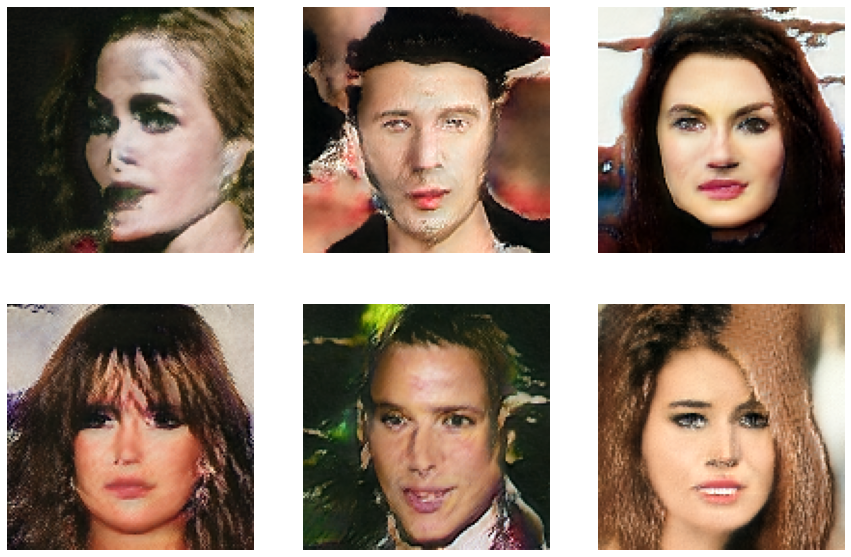

In [183]:
images = gan.generate(z)
plot_images(images, 7)

# Style Mixing

In [ ]:
for j in range(len(w)):

    w_a = w[0]
    w_b = w[j]
    image_a = generate_image(w_a, noise)[0]
    image_b = generate_image(w_b, noise)[0]

    w_i= 2
    w_mix = tf.concat([w_a[:w_i], 
                       w_b[w_i:]], axis=0)
    image_mix = generate_image(w_mix, noise)[0]
    images = np.stack([image_a, image_b, image_mix], axis=0)
    plot_images(images, 7)

## Same Style, Different Noise

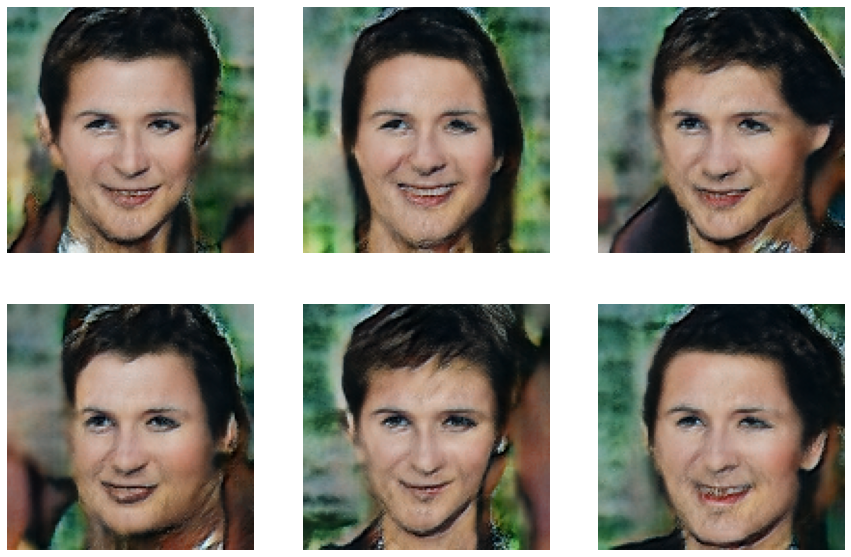

In [92]:
noise = gan.generate_noise(batch_size)
images = generate_image(w[2], noise)
plot_images(images, 7)

In [ ]:
tf.keras.utils.plot_model(gan.discriminator, show_shapes=True)

In [ ]:
tf.keras.utils.plot_model(gan.generator, show_shapes=True)

In [ ]:
tf.keras.utils.plot_model(gan.model, show_shapes=True)